_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Project 3: Single-cell data analysis.

In [61]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##
import seaborn as sns

import time
import pickle

# import memory_profiler

# %load_ext memory_profiler

from pathlib import Path

In [62]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [63]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [64]:
plt.style.use(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/matplotlib_style.txt"
)

In [65]:
np.random.seed(42)

## Project and data description

In this project, we are going to work with the typical methods and pipelines used in single-cell data analysis and get some hands-on experience with the techniques used in the field. For that, we will be using Patch-seq multimodal data from cortical neurons in mice, from Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). From the different data modalities they used, we will focus on transcriptomics and electrophysiological data. 

In a real-world scenario, single cell data rarely comes with any "ground truth" labels. Often, the goal of researchers after measuring cells is to precisely classify them, grouping them into families or assigning them cell types based on the recorded features. This is normally done using usupervised methods, such as clustering methods.

However, the single-cell data that we are using in this project has some cell types assigned to each cell. These are not "ground truth" type annotations, but were one of the results from the original Scala et al. work. Still, we are going to use those annotations for validation (despite them not really being ground truth) to sanity-check some of our analyses, such as visualizations, clustering, etc. We will mainly work with cell types (`rna_types`, 77 unique types) and cell families (`rna_families`, 9 unique families).

From the transcriptomics mRNA counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out.

## Import data

### Meta data

In [66]:
# META DATA

meta = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/m1_patchseq_meta_data.csv",
    sep="\t",
)

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


In [67]:
meta.columns

Index(['Number', 'Cell', 'Slice', 'Date', 'Sample', 'Mouse',
       'Mouse date of birth', 'Mouse age', 'Mouse gender', 'Mouse genotype',
       'Targeted layer', 'Inferred layer', 'Cre', 'Exon reads', 'Intron reads',
       'Intergenic reads', 'Sequencing batch', 'Number of genes detected',
       'RNA family', 'RNA type', 'RNA type confidence', 'RNA type top-3',
       'ALM/VISp top-3', 'Length (bp)', 'Yield (pg/µl)', 'User',
       'Hold Time (min)', 'Soma depth (µm)', 'Soma depth (4x)',
       'Cortical thickness (4x)', 'Cortical thickness (µm)', 'Traced',
       'Exclusion reasons'],
      dtype='object')

In [68]:
meta.head

<bound method NDFrame.head of       Number               Cell             Slice        Date    Sample  \
0          1  20171204_sample_2  20171204_slice_2  2017-12-04  sample 2   
1          2  20171204_sample_4  20171204_slice_4  2017-12-04  sample 4   
2          3  20171204_sample_5  20171204_slice_5  2017-12-04  sample 5   
3          4  20171204_sample_6  20171204_slice_6  2017-12-04  sample 6   
4          5  20171207_sample_1  20171207_slice_1  2017-12-07  sample 1   
...      ...                ...               ...         ...       ...   
1324    1325  20200225_sample_2  20200225_slice_2  2020-02-25  Sample 2   
1325    1326  20200225_sample_5  20200225_slice_5  2020-02-25  Sample 5   
1326    1327  20200316_sample_1  20200316_slice_1  2020-03-16  Sample 1   
1327    1328  20200316_sample_2  20200316_slice_2  2020-03-16  Sample 2   
1328    1329  20200316_sample_3  20200316_slice_3  2020-03-16  Sample 3   

            Mouse Mouse date of birth  Mouse age Mouse gender  \
0   

### "Ground truth labels"

In [69]:
# filter out low quality cells in term of RNA
print(
    "There are",
    np.sum(meta["RNA family"] == "low quality"),
    "cells with low quality RNA recordings.",
)
exclude_low_quality = meta["RNA family"] != "low quality"

There are 97 cells with low quality RNA recordings.


In [70]:
rna_family = meta["RNA family"][exclude_low_quality]
rna_type = meta["RNA type"][exclude_low_quality]

In [71]:
print(len(np.unique(rna_family)))
print(len(np.unique(rna_type)))

9
77


In [72]:
pickle_in = open(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/dict_rna_type_colors.pkl",
    "rb",
)
dict_rna_type_colors = pickle.load(pickle_in)

In [73]:
rna_type_colors = np.vectorize(dict_rna_type_colors.get)(rna_type)

### Transcriptomic data

In [74]:
# READ COUNTS
data_exons = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/m1_patchseq_exon_counts.csv.gz",
    na_filter=False,
    index_col=0,
)

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

# filter out low quality cells in term of rna family
exonCounts = data_exons.values.transpose()[exclude_low_quality]
print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1232, 42466)


In [75]:
# GENE LENGTH

data = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/gene_lengths.txt"
)
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values

### Electrophysiological features

In [76]:
# EPHYS DATA

ephysData = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/m1_patchseq_ephys_features.csv"
)
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [77]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData[exclude_low_quality]
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1232, 29)
(1224, 17)


In [78]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

# Research questions to investigate

**1) Inspect the data by computing key statistics.** For RNA counts, you can compute and plot statistics, e.g. total counts per cell, number of expressed genes per cell, mean count per gene, variance per gene, mean-variance relationship... See https://www.embopress.org/doi/full/10.15252/msb.20188746 for common quality control statistics. Keep in mind that the RNA data in this project is read counts, not UMI counts, so it is not supposed to follow a Poisson distribution. To get an idea of the technical noise in the data, you can plot count distributions of single genes within cell types (like in the lecture). 

Similarly, you can compute and plot statistics over the electrophyiological data. Also, investigate the distribution of "ground truth" labels. Comment about other relevant metadata, and think if you can use it as some external validation for other analyses. If you do use other metadata throughout the project, explain why and what you get out of it. Take into account that certain features may not be very informative for our purposes (e.g. mouse age), so only choose features that provide you with useful information in this context. If you want to get additional information about the metadata, have a look at the extended data section in the original publication (e.g., cre-lines in Figure 1c in the extended data).

**2) Normalize & transform the data; select genes & apply PCA.** There are several ways of normalizing the RNA count data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data, but not for this read count data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization. After normalization and transformation, choose a set of highly variable genes (as demonstrated in the lecture) and apply PCA. Play with the number of selected genes and the number of PCA components, and again compare their effects on the two-dimensional visualization.

**3) Two-dimensional visualization.** To visualize the RNA count data after normalization, transformation, gene selection and PCA, try different methods (just PCA, t-SNE, UMAP, ..) and vary their parameters (exaggeration, perplexity, ..). Compare them using quantitative metrics (e.g., kNN accuracy in high-dim vs. two-dim, kNN recall). Please refer to Lause et al., 2024 (https://doi.org/10.1371/journal.pcbi.1012403) where many of these metrics are discussed and explained to make an informed choice on which metrics to use. Think about also using the electrophysiological features and other metadata to enhance different visualizations.

**4) Clustering.** To find cell types in the RNA count data, you will need to look for clusters. Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2). Feel free to simplify the setup from the paper and not optimize over the set of important genes S but fix it instead, or skip the split and merge part of their clustering algorithm. A vanilla NBMM implementation should suffice. Take into account that the NBMM tries to cluster data that follows a negative binomial distribution. Therefore, it does not make sense to apply this clustering method to all kinds of normalized and transformed data. Please refer to the Harris et al. 2018 publication for the appropriate choice of normalization, and reflect on why this normalization makes sense. Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation between electrophysiological features and genes/PCs.** Finally, connect RNA counts and functional data: Most likely, there will be interesting relationships between the transcriptomic and electrophyiological features in this data. Find these correlations and a way of visualizing them. In studying correlations using the PCA-reduced version of the transcriptomics data, it could be interesting to study PC loadings to see which genes are dominating which PCs. For other advanced analyses, you can get inspitation from Kobak et al., 2021 (https://doi.org/10.1111/rssc.12494).
    

**1) Inspect the data by computing key statistics**

as from referenced paper: “QC covariates should be considered jointly … and thresholds should be set as permissive as possible to avoid filtering out viable cell populations unintentionally.”

Per cell statistics:
- Total counts per cell: The sum of all gene counts in a cell (cell "library size"/sequencing depth).
- Number of expressed genes per cell: How many genes have nonzero counts in each cell (cell “complexity”).
- Fraction of mitochondrial counts per cell (optional, but standard in scRNA-seq, if mitochondrial genes are annotated): High values can indicate damaged cells.

Per-gene statistics:
- Mean count per gene: Average expression of each gene across all cells.
- Variance per gene: Variability of each gene’s expression across all cells.
- Mean-variance relationship: Plot mean expression vs variance for genes—a key plot in single-cell to spot technical noise and variability.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/3266939196.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


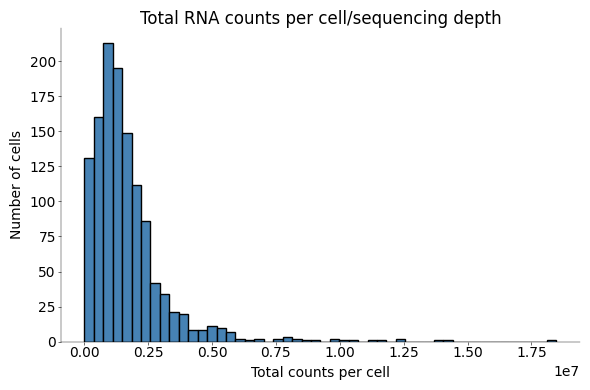

In [79]:
# 1. Total counts per cell
total_counts_per_cell = exonCounts.sum(axis=1)

plt.figure(figsize=(6, 4))
plt.hist(total_counts_per_cell, bins=50, color="steelblue", edgecolor="k")
plt.xlabel("Total counts per cell")
plt.ylabel("Number of cells")
plt.title("Total RNA counts per cell/sequencing depth")
plt.tight_layout()
plt.show()

- Most cells have between about 0.5 million to 3 million counts
- Right-skewed distribution: Long tail towards higher values
- Very high outliers: A handful of cells have extremely high counts (up to ~17 million). These might be doublets (two cells captured together) or could just be very large/active cells

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/961360937.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


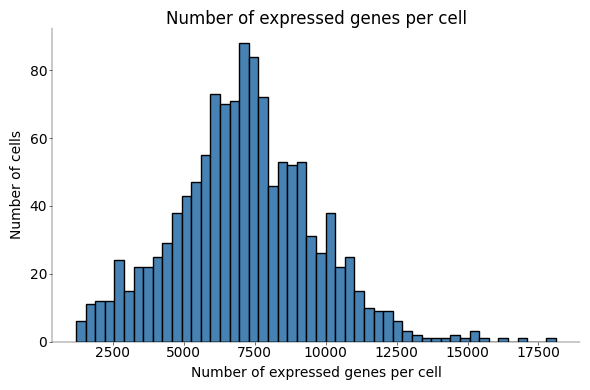

In [80]:
# 2. Number of expressed genes per cell
num_genes_per_cell = (exonCounts > 0).sum(axis=1)

plt.figure(figsize=(6, 4))
plt.hist(num_genes_per_cell, bins=50, color="steelblue", edgecolor="k")
plt.xlabel("Number of expressed genes per cell")
plt.ylabel("Number of cells")
plt.title("Number of expressed genes per cell")
plt.tight_layout()
plt.show()

- Most cells have 5,000 to 9,000 detected genes
- Distribution shape: This is roughly normal, with some spread to both lower and higher numbers
- Few low outliers: Some cells have as few as ~2,000 expressed genes. These could be lower-quality or rare cell types
- High outliers: Some cells have up to ~17,500 genes detected. These might be doublets or very large cells

- --> No obvious huge population of low-quality cells.
- --> Small tails on both ends—totally normal.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/3384435424.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


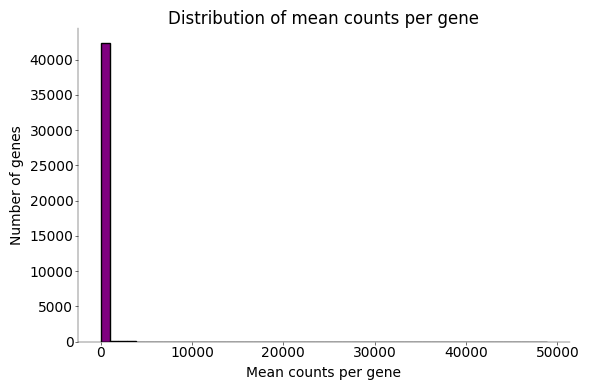

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/3384435424.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


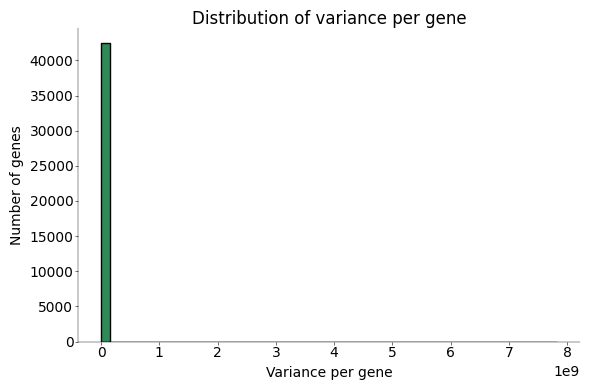

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/3384435424.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


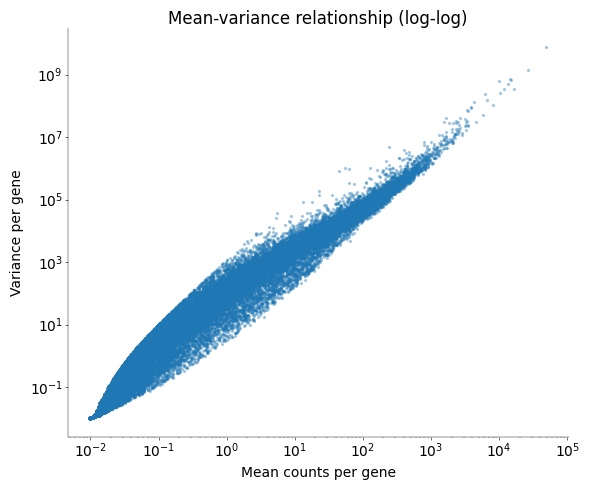

In [81]:
# 3. Mean and variance per gene
mean_counts_per_gene = exonCounts.mean(axis=0)
var_counts_per_gene = exonCounts.var(axis=0)

plt.figure(figsize=(6, 4))
plt.hist(mean_counts_per_gene, bins=50, color="purple", edgecolor="k")
plt.xlabel("Mean counts per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of mean counts per gene")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(var_counts_per_gene, bins=50, color="seagreen", edgecolor="k")
plt.xlabel("Variance per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of variance per gene")
plt.tight_layout()
plt.show()

# 4. Mean-variance relationship (log-log)
plt.figure(figsize=(6, 5))
plt.scatter(
    mean_counts_per_gene + 1e-2, var_counts_per_gene + 1e-2, alpha=0.3, s=8
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean counts per gene")
plt.ylabel("Variance per gene")
plt.title("Mean-variance relationship (log-log)")
plt.tight_layout()
plt.show()

distribution of mean counts per gene
- Huge spike near zero: The vast majority of genes have a very low mean expression across all cells. This is normal—many genes are simply not “on” in most cells, or only expressed in rare cell types
- This is exactly what you expect for scRNA-seq—most genes are off or expressed at low levels, and a minority are expressed at high levels.

distribution of variance per gene
- Most genes have very low variance: This is expected—if a gene is always off, its variance is close to zero
- 

mean variance relationship
- Strong linear relationship on log-log scale: Most points (genes) fall along a line, with variance increasing as the mean increases
- Spread at high mean: At higher mean, some genes have even higher variance—these are likely biologically variable or subject to strong regulation

Most genes have low mean expression and low variance, reflecting the sparse nature of single-cell transcriptomics. A subset of genes show high mean and/or variance, representing genes that are either highly or heterogeneously expressed across cell types. The mean-variance relationship shows a clear positive trend, as expected, with overdispersion typical of read count data.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/4191436859.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


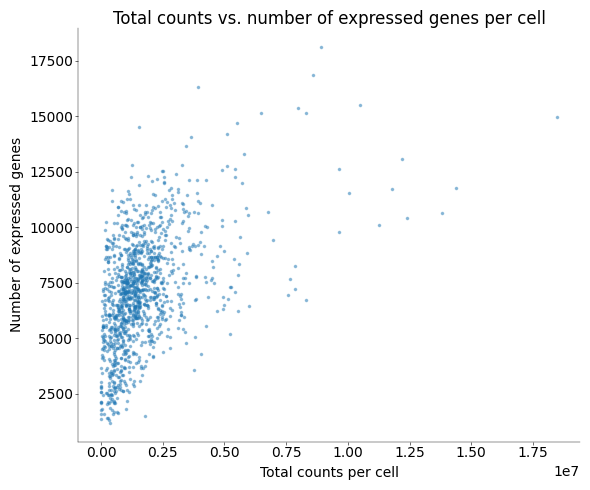

In [82]:
# 5. Scatter: total counts vs. number of expressed genes (per cell)
plt.figure(figsize=(6, 5))
plt.scatter(total_counts_per_cell, num_genes_per_cell, alpha=0.4, s=10)
plt.xlabel("Total counts per cell")
plt.ylabel("Number of expressed genes")
plt.title("Total counts vs. number of expressed genes per cell")
plt.tight_layout()
plt.show()

- Most cells cluster tightly in a main cloud (lower left to mid-right), showing the expected trend: more counts → more genes detected
- few cells are outliers with much higher total counts and/or more detected genes. These are rare, so not a major concern.

In [83]:
marker_genes = ["Pvalb", "Sst", "Vip", "Snap25", "Slc17a7", "Gad2"]
for g in marker_genes:
    if g in genes:
        print(f"{g} found in genes array!")

Pvalb found in genes array!
Sst found in genes array!
Vip found in genes array!
Snap25 found in genes array!
Slc17a7 found in genes array!
Gad2 found in genes array!


In [84]:
# 6. Example: Distribution of counts for a single gene in a single cell type
# Choose a gene and cell type (replace with ones relevant to your data)
# print(genes[:100])  # first 100 genes
# print(np.unique(rna_type))  # See available cell types

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/3982122258.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


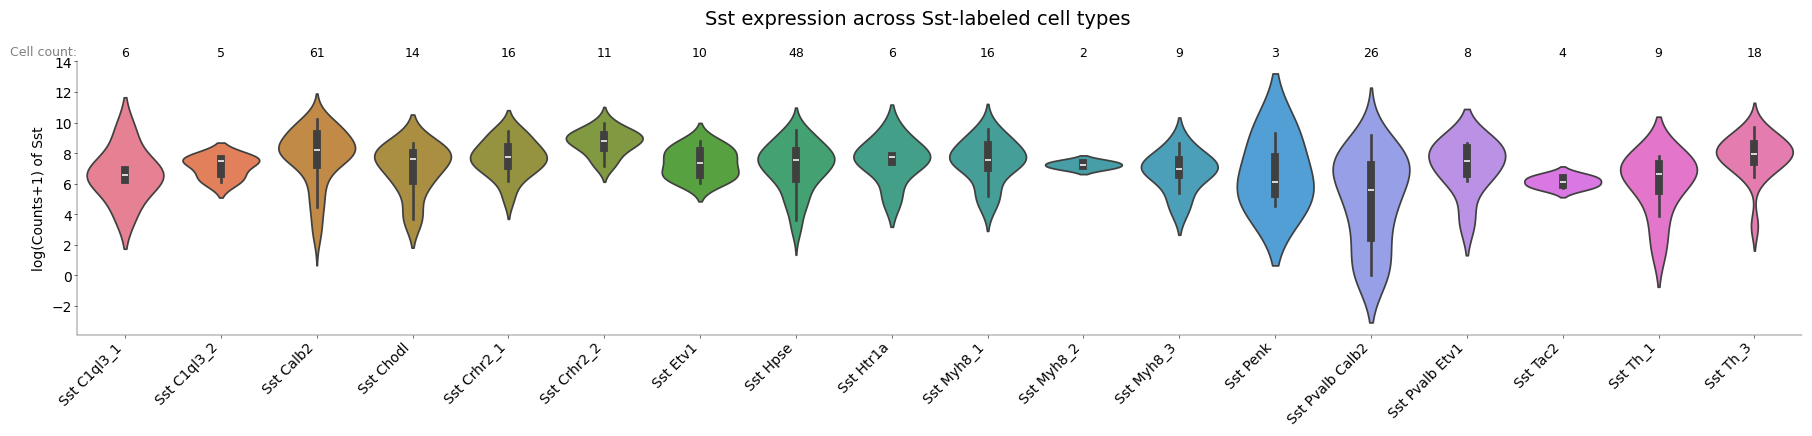

In [ ]:
# --------
# 1. Violin/boxplot of a marker gene ('Pvalb') across related cell types
# --------
marker_gene = "Sst"
gene_idx = np.where(genes == marker_gene)[0][0]

related_cell_types = [
    ct for ct in np.unique(rna_type) if ct.startswith(marker_gene)
]

data = []
labels = []
cell_counts = []
for ct in related_cell_types:
    mask = rna_type == ct
    if np.any(mask):
        data.append(np.log1p(exonCounts[mask, gene_idx]))
        labels.append(ct)
        cell_counts.append(np.sum(mask))

plt.figure(figsize=(max(6, len(labels)), 4))
ax = sns.violinplot(data=data, inner="box")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylabel(f"log(Counts+1) of {marker_gene}")
plt.tight_layout()

# Add cell count annotations above each violin
ymax = plt.ylim()[1]
for i, count in enumerate(cell_counts):
    plt.text(
        i,
        ymax * 1.01,
        str(count),
        ha="center",
        va="bottom",
        fontsize=9,
        color="black",
    )

# Move 'Cell count:' label far left
plt.text(-1.2, ymax * 1.03, "Cell count:", fontsize=9, color="gray")

# Set the main title *above* the counts
plt.suptitle(
    f"{marker_gene} expression across {marker_gene}-labeled cell types",
    y=1.08,
    fontsize=14,
)

plt.show()

Each “violin” shows the spread of Sst gene expression in cell type
- Wider = more cells with that expression value
- Center line/box = median/interquartile range

- Most violins are centered around log-counts of ~7–10+.
- A few subtypes show a broader or lower distribution: For example, some “Sst Pvalb Calb2” cells have lower Sst expression and/or more spread. This could mean these subtypes are more mixed, or have biological/annotation variability.
- Some subtypes (like “Sst Myh8_2” and “Sst Tac2”) have less spread: Likely fewer cells, or a more homogeneous expression pattern.

Expression of the Sst marker gene is consistently high across all Sst-labeled interneuron subtypes, supporting the validity of the transcriptomic annotations. Some subtypes show broader or more variable Sst expression, reflecting either biological diversity or mixed-type annotations. This confirms that Sst is a robust marker for these interneurons and supports using these labels for validation in downstream analyses.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/2766796898.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


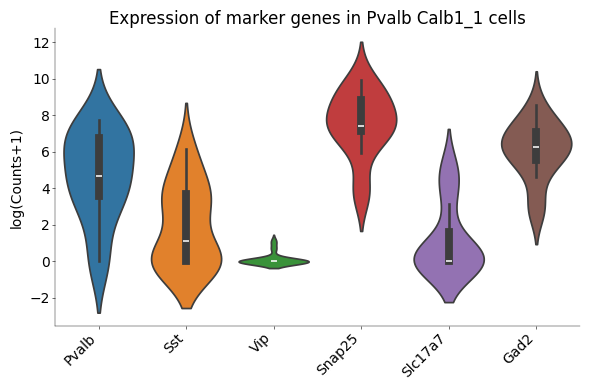

In [86]:
# --------
# 2. Violin/boxplot of multiple marker genes in one cell type
# --------
cell_type = "Pvalb Calb1_1"
genes_to_check = ["Pvalb", "Sst", "Vip", "Snap25", "Slc17a7", "Gad2"]

# Get indices, skipping missing genes
gene_indices = [
    np.where(genes == g)[0][0] for g in genes_to_check if g in genes
]
gene_labels = [g for g in genes_to_check if g in genes]

mask = rna_type == cell_type
data = [np.log1p(exonCounts[mask, idx]) for idx in gene_indices]

plt.figure(figsize=(max(6, len(gene_labels)), 4))
sns.violinplot(data=data, inner="box")
plt.xticks(range(len(gene_labels)), gene_labels, rotation=45, ha="right")
plt.ylabel("log(Counts+1)")
plt.title(f"Expression of marker genes in {cell_type} cells")
plt.tight_layout()
plt.show()

open questions 
- should we normalize for sequencing depth?
- variance stabilizing tarnsformations
- paper from which the data is from: Plots correlations between marker gene expression and electrophysiological features (see their Fig 2/4)—which sets you up for your next project steps!

Show Sst expression is high in Sst subtypes, but low (ideally near zero) in others.

- potentially add “marker-negative” controls --> negative control 
It shows at a glance that your marker gene is not just highly expressed in the marker-positive types (e.g., Sst subtypes), but truly absent (or much lower) in unrelated types (e.g., Pvalb, Vip, Lamp5, excitatory).

Compare Marker Gene Expression Across Major Families
- For each major family (e.g., Sst, Pvalb, Vip, Lamp5, excitatory), plot its marker gene in that family and others.
- Show that expression is family-specific.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/500998276.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='family', y='log_counts', data=df[df['family'].isin(order)],
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/500998276.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


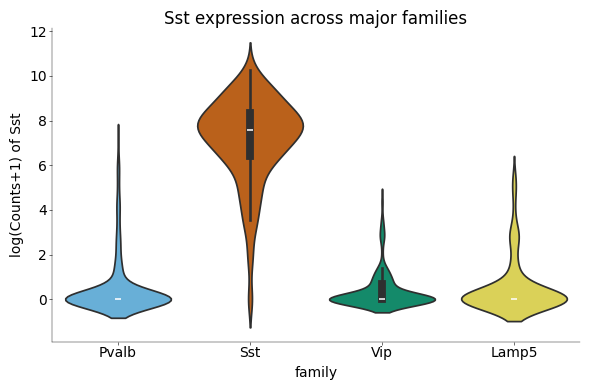

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/500998276.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='family', y='log_counts', data=df[df['family'].isin(order)],
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/500998276.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


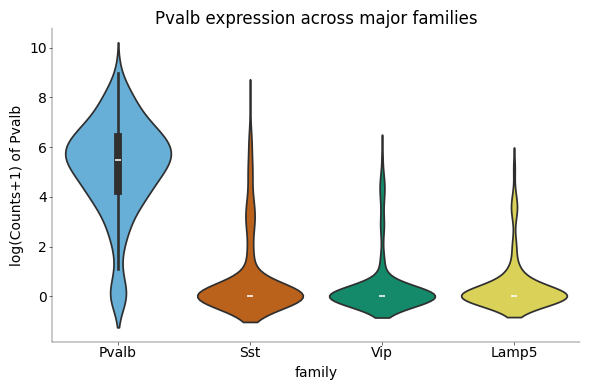

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/500998276.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='family', y='log_counts', data=df[df['family'].isin(order)],
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/500998276.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


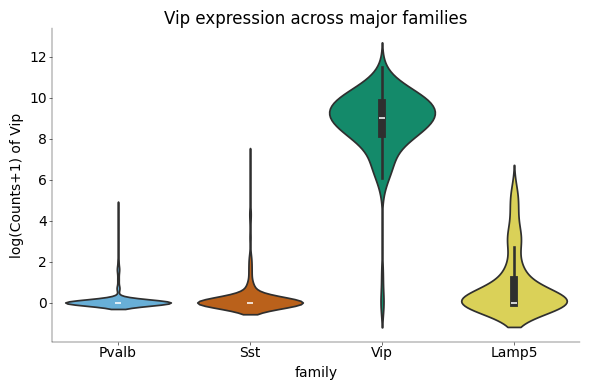

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/500998276.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='family', y='log_counts', data=df[df['family'].isin(order)],
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/500998276.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


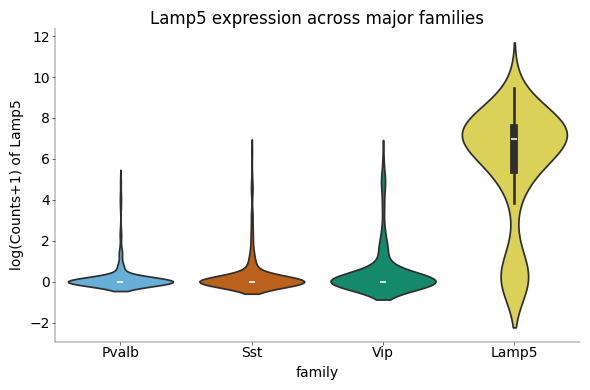

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/500998276.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='family', y='log_counts', data=df[df['family'].isin(order)],
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_28442/500998276.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


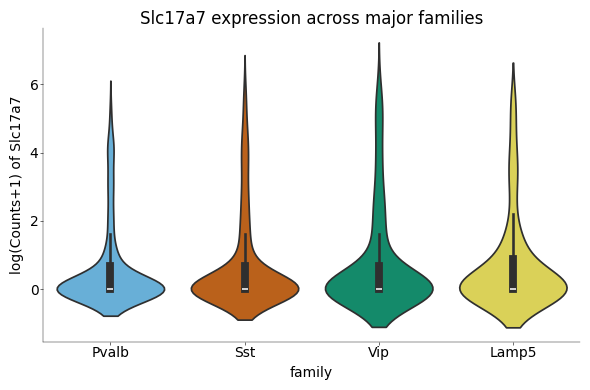

In [ ]:
# Extract family from cell_type (first word before space)
families = np.array([ct.split()[0] for ct in rna_type])

marker_genes = [
    "Sst",
    "Pvalb",
    "Vip",
    "Lamp5",
    "Slc17a7",
]  # last one is excitatory neuron marker
family_colors = {
    "Sst": "#56B4E9",
    "Pvalb": "#D55E00",
    "Vip": "#009E73",
    "Lamp5": "#F0E442",
    "Slc17a7": "#0072B2",
}

for marker in marker_genes:
    gene_idx = np.where(genes == marker)[0][0]
    df = pd.DataFrame(
        {"family": families, "log_counts": np.log1p(exonCounts[:, gene_idx])}
    )
    # Only show major families present in your data
    fam_counts = df["family"].value_counts()
    families_to_plot = [fam for fam in marker_genes if fam in fam_counts.index]
    order = families_to_plot

    plt.figure(figsize=(max(6, len(order)), 4))
    sns.violinplot(
        x="family",
        y="log_counts",
        data=df[df["family"].isin(order)],
        palette=[family_colors.get(f, "gray") for f in order],
    )
    plt.ylabel(f"log(Counts+1) of {marker}")
    plt.title(f"{marker} expression across major families")
    plt.tight_layout()
    plt.show()